In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb/listings/listings-chicago.csv
/kaggle/input/airbnb/listings/listings-boston.csv
/kaggle/input/airbnb/listings/listings-seattle.csv
/kaggle/input/airbnb/listings/listings-ny.csv
/kaggle/input/airbnb/calendar/calendar-chicago.csv
/kaggle/input/airbnb/calendar/calendar-ny.csv
/kaggle/input/airbnb/calendar/calendar-seattle.csv
/kaggle/input/airbnb/calendar/calendar-boston.csv


# Reading the listings of the cities - New York, Seattle, Boston, Chicago

In [3]:
pd.set_option('display.max_columns', None)

def get_listings():
    ny = pd.read_csv('/kaggle/input/airbnb/listings/listings-ny.csv')
    seattle = pd.read_csv('/kaggle/input/airbnb/listings/listings-seattle.csv')
    boston = pd.read_csv('/kaggle/input/airbnb/listings/listings-boston.csv')
    chicago = pd.read_csv('/kaggle/input/airbnb/listings/listings-chicago.csv')
    df = pd.concat([ny, seattle, boston, chicago])
    return df

In [19]:
df = get_listings()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


# Printing all the columns available in the dataset. 
Many columns in the data are irrelevant and can be dropped. The columns that would provide no useful information during EDA/modelling can be dropped to perform effective EDA.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59027 entries, 0 to 7624
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            59027 non-null  int64  
 1   listing_url                                   59027 non-null  object 
 2   scrape_id                                     59027 non-null  int64  
 3   last_scraped                                  59027 non-null  object 
 4   source                                        59027 non-null  object 
 5   name                                          59014 non-null  object 
 6   description                                   58196 non-null  object 
 7   neighborhood_overview                         36273 non-null  object 
 8   picture_url                                   59027 non-null  object 
 9   host_id                                       59027 non-null  

# Preprocessing 1: Dropping columns
The columns required for EDA and modeling are chosen, and the others are removed.

In [21]:
df = df[['id', 'host_id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 
         'host_total_listings_count', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 
         'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'amenities', 'minimum_nights', 'maximum_nights', 'availability_30', 
         'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'last_review', 'review_scores_rating', 
         'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
         'review_scores_value','calculated_host_listings_count', 'license', 'reviews_per_month']]

# Exploratory Data Analysis 1: Plotting Bar Graph Specifying Number of Missing Values for each column
Here, in the beginning we are seeing the number of missing values in each column. It helps us in finding columns which don’t have much Information. This step helped us in finding columns like licenses in which most columns were NULL. This led to us dropping this column.
Also using this bar graph we found that columns like reviews are null for some columns through which we were able to infer that NULL in this case can be changed by filling the places where it is NULL by zero. In such case we keep the relevant column that can be later used in modelling also.


<AxesSubplot:>

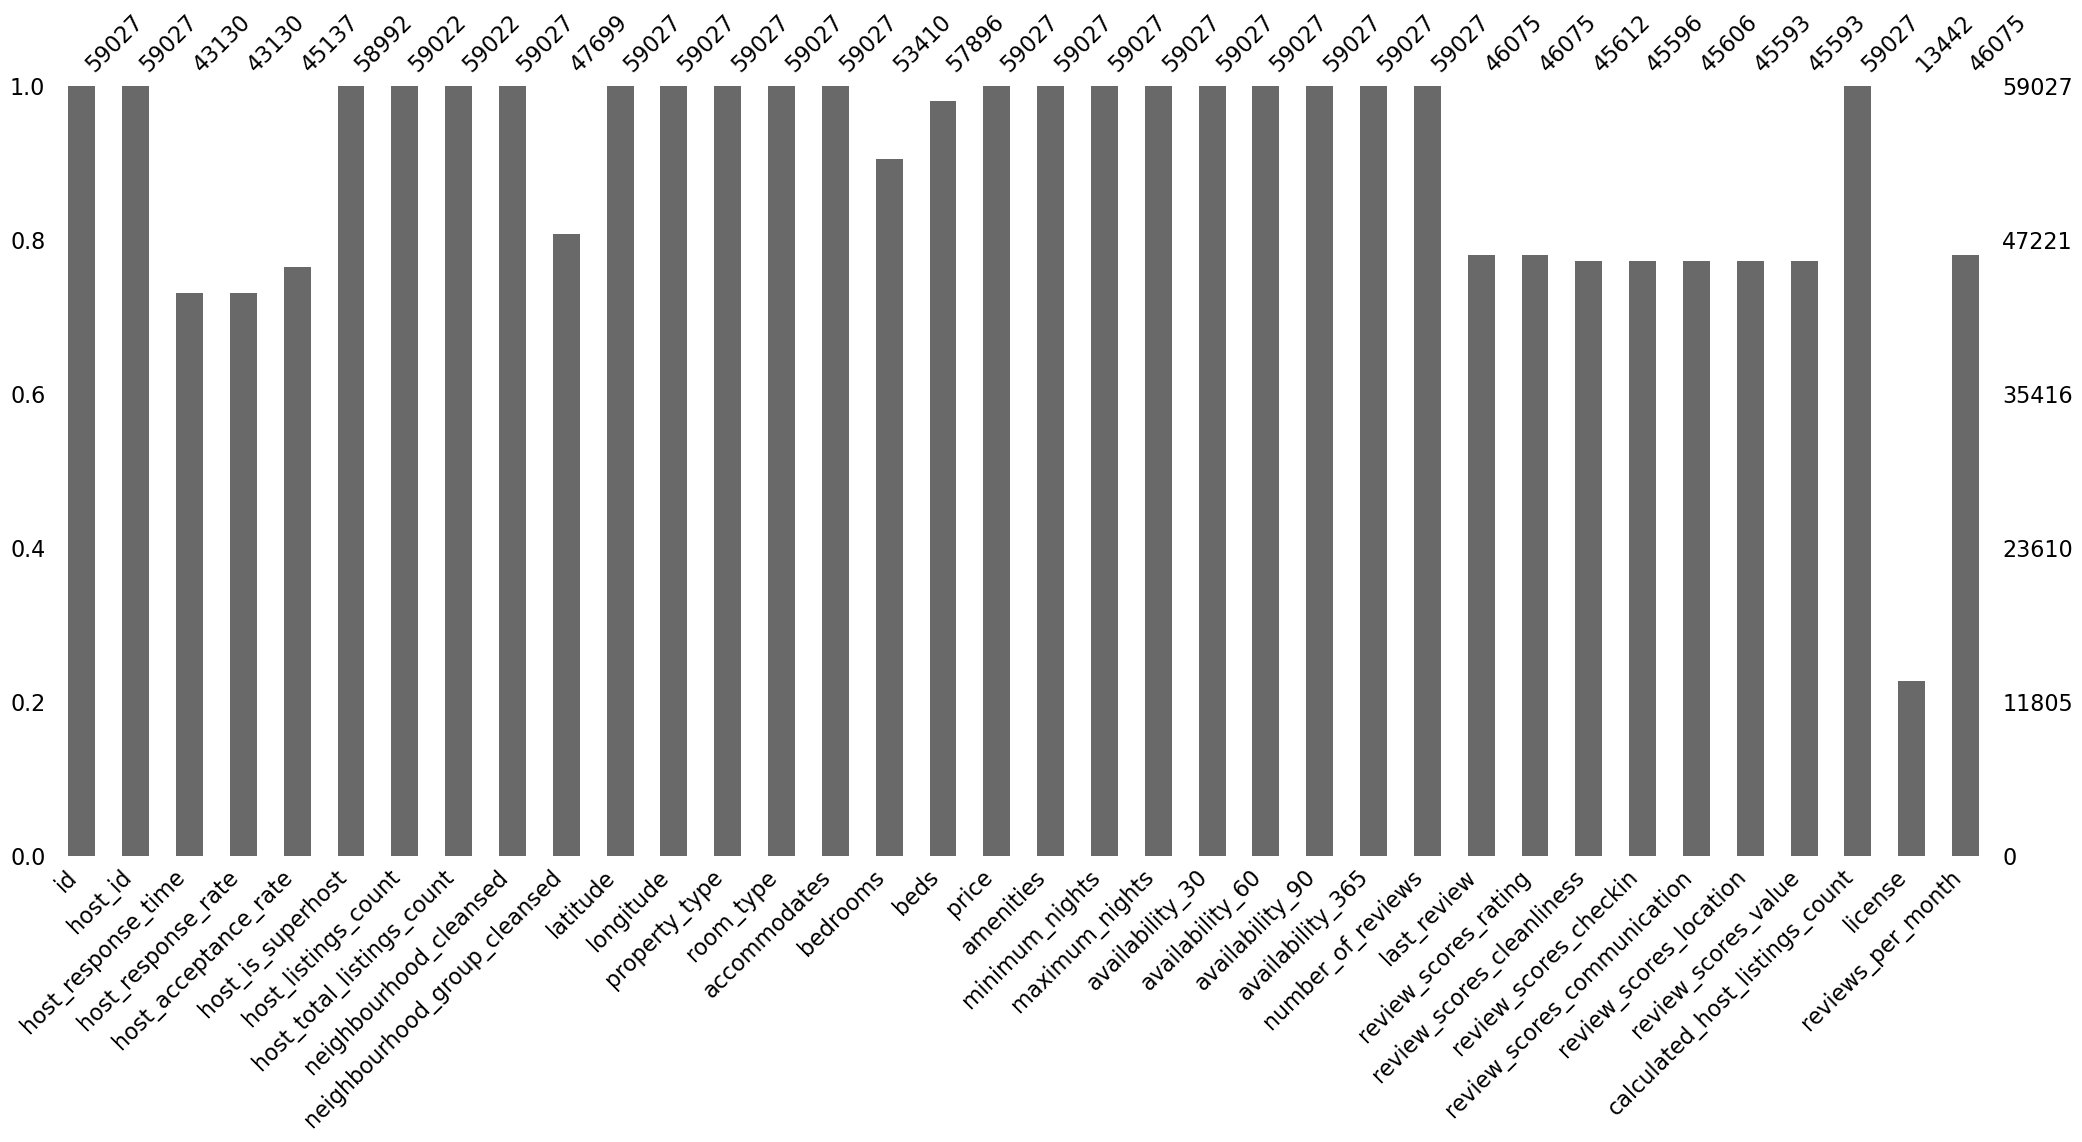

In [22]:
msno.bar(df)

About 74% the entires in the column <b>license</b> are NULL. Therefore dropping the column.

In [23]:
df.drop('license', axis=1, inplace=True)

# Preprocessing 2: Fill missing values
We decided to fill the <b>NULL</b> values with <b>0</b> for `reviews_per_month` since the listing could be new, low occupancy, or removed reviews.

In [24]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Preprocessing 3: Changing the column values to categorical
Here, we are converting the string columns to categorical data. We are changing the field host_is_superhost to categorical since superhosts usually have high rating due to their hospitability, reliability and responsiveness. The field host_is_superhost contains either t or f denoting superhost or not. This data is converted into 1 for superhost and 0 for not a superhost.

In [25]:
df['host_is_superhost'] = df['host_is_superhost'].astype('category').cat.codes

In [26]:
df.duplicated().sum()

0

# Preprocessing 4: Removing duplicate rows
In this step, we found that the data contained around 70 duplicates. Therefore, we removed it by dropping the rows associated with the rows.

In [27]:
df.drop_duplicates(inplace=True)

# Preprocessing 5: Formatting columns and converting to required type
The entry in price column consisted of **\\$** sign followed by the integer price with comma’s separating digits. To make the data consistent and usable for EDA, we removed the **\\$**,  sign and comma in the **price** column and converted the data type to **float**.</br>
Similar to price column, **host_response_rate** consisted of the response rate in percentage along with **%** (eg. 98%) in the data. Therefore, we removed the **%** from the column and converted the datatype to **float** and additionally filling the empty values with 0.

In [28]:
# Remove $ sign and convert to float
def preprocess_price(price):
    if pd.isna(price):
        return np.NaN
    else:
        return float(price.replace("$","").replace(",","").replace(" ",""))

# Remove % sign and convert to float
def preprocess_response_rate(response_rate):
    if pd.isna(response_rate):
        return 0
    else:
        return float(response_rate.replace("%","").replace(",","").replace(" ",""))

df['price'] = df['price'].apply(preprocess_price)

df['host_response_rate'] = df['host_response_rate'].apply(preprocess_response_rate)
df['host_response_rate'] = df['host_response_rate'].fillna(0)

# Preprocessing 6: Introducing new columns
This step was necessary to create new columns and find the correlation with other columns during EDA. We introduced two columns: </br>
* **amenities_count**: The data consisted of an amenities column for which the values were a string consisting of the following special characters **[, ], “, and ,**. Thus we parsed the string to split and counted the total number of amenities in each of the listings. We speculated that the count could be directly proportional to the price of the listing.

* **price_per_room**: This field is to denote the price per bedroom of the listing. This column is necessary to determine the relation between the room type and the price or find the average prices of each room in the neighborhood.


In [29]:
def preprocess_amenities(value):
    value = re.sub('["\[\]]+', '', value)
    return len(value.split(","))


df['amenities_count'] = df['amenities'].apply(preprocess_amenities)
df['price_per_room'] = df['price']/df['bedrooms']

# Preprocessing 7: Strings processing
This step is applicable for all the object or string fields. The fields had inconsistent casing, extra whitespaces and even special characters. Thus, it was cleaned to make all the string columns uniform in the entire dataset. Following are the processing steps for the string fields
* Striping white spaces
* Replace special characters using regex
* Convert the text to lowercase

In [30]:
df.select_dtypes(["object"]).columns

Index(['host_response_time', 'host_acceptance_rate', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'amenities', 'last_review'],
      dtype='object')

In [31]:
df_columns = df.select_dtypes(["object"])
df[df_columns.columns] = df_columns.apply(lambda x: x.str.strip())
df[df_columns.columns] = df_columns.apply(lambda x: x.str.replace(r'[^A-Za-z0-9]+', '', regex=True))
df[df_columns.columns] = df_columns.apply(lambda x: x.str.lower())

# Exploratory Data Analysis 2: Describing the Summary Statistics of data
In this step we described the summary statistics for each column to understand the spread of value in them by seeing the mean, standard deviation, max, min, etc. By plotting this we could see that the min max for columns like price was very far from mean even though the standard deviation was very less which helped us identify outliers in that column. Also we saw for **host_listing_count** the min was **zero** which helped us identify the irrelevant data.
This EDA helped us in outlier removal with irrelevant data removal.

In [32]:
df.describe()

,id,host_id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,amenities_count,price_per_room
count,5.902700e+04,5.902700e+04,59027.000000,59027.000000,59022.000000,59022.000000,59027.000000,59027.000000,59027.000000,53410.000000,57896.000000,59027.000000,59027.000000,5.902700e+04,59027.000000,59027.000000,59027.000000,59027.000000,59027.000000,46075.000000,45612.000000,45596.000000,45606.000000,45593.000000,45593.000000,59027.000000,59027.000000,59027.000000,53410.000000
mean,1.866941e+17,1.412658e+08,69.787131,0.258610,183.552116,239.217597,41.700428,-80.591606,3.246921,1.499626,1.781695,210.907846,18.224474,3.764318e+04,10.116625,25.971183,42.696207,162.185644,33.541955,4.665790,4.671129,4.826690,4.822180,4.754803,4.655871,29.818168,1.178511,29.549562,149.508990
std,3.045822e+17,1.505584e+08,43.984597,0.439227,824.653095,1012.512454,2.089628,15.008135,2.314907,0.898222,1.313570,958.600533,32.260082,8.839789e+06,11.085356,23.097710,35.511750,143.684696,69.263024,0.649159,0.499916,0.390786,0.409758,0.387520,0.465323,96.047140,1.862615,15.746317,874.848658
min,2.384000e+03,2.153000e+03,0.000000,-1.000000,0.000000,0.000000,40.500314,-122.419050,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.200000
25%,2.066780e+07,1.705622e+07,0.000000,0.000000,1.000000,1.000000,40.704740,-74.010760,2.000000,1.000000,1.000000,80.000000,2.000000,6.000000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,4.620000,4.570000,4.810000,4.820000,4.670000,4.560000,1.000000,0.020000,17.000000,65.000000
50%,4.351317e+07,7.672883e+07,100.000000,0.000000,2.000000,3.000000,40.757480,-73.964500,2.000000,1.000000,1.000000,130.000000,5.000000,3.650000e+02,5.000000,28.000000,51.000000,146.000000,7.000000,4.840000,4.830000,4.950000,4.960000,4.870000,4.770000,2.000000,0.390000,28.000000,98.000000
75%,5.748743e+17,2.415539e+08,100.000000,1.000000,8.000000,11.000000,41.885535,-73.927710,4.000000,2.000000,2.000000,210.000000,30.000000,1.125000e+03,20.000000,48.000000,77.000000,328.000000,34.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.930000,6.000000,1.790000,40.000000,150.000000
max,7.879224e+17,4.919696e+08,100.000000,1.000000,4648.000000,12017.000000,47.734010,-70.996000,16.000000,16.000000,42.000000,99998.000000,1250.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,2847.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,639.000000,102.980000,105.000000,98159.000000


# Preprocessing 8: Removing outliers and irrelevant data
* **host_listing_count** and **accommodates** both contained 0 values. These values are outliers as the Airbnb listing wouldn’t make sense if value of these columns could be 0. Thus, we removed the outliers by only considering all the listings with host_listing_count and accommodates greater than 0.
* **price**: The price also consisted of outliers as the maximum price of all the listings was **\\$98k** which is way above the mean of $209. Therefore, we removed the listings with price greater than 500.
* **neighborhood_group_cleansed**: Listings with no neighborhood group were removed as the price also differs based on the location. Thus, listings with null data would affect the EDA and limit the learning process of model in the future.
* **amenities_count**: With the help of EDA, the amenities count contained outliers when greater than 90. Therefore, we dropped the rows if the count is greater than 90.
* **room_type**: The listing with hotel rooms were less than 0.5% of the entire data. Therefore, removed the rows that matched the room type as hotel due to lack of data.

In [33]:
# Preprocessing Step 8: Removing outliers and irrelevant data
df = df[df['host_listings_count'] > 0]
df = df[df['accommodates'] > 0]
df = df[df['price'] > 0]
df = df[df['price'] <= 500]
df = df[df['neighbourhood_group_cleansed'].notna()]

# Preprocessing 9: Dropping rows with NULL values
After performing all the above cleaning, the rows with null values are discarded as they would provide very little information and hurt EDA and modelling process.

In [35]:
df.shape

(45063, 37)

In [36]:
df.dropna(inplace=True)

In [37]:
df.shape

(22438, 37)

# Exploratory Data Analysis 3: Plotting Neighborhood with the most Airbnb
In this graph we plotted the count of Airbnb's in a particular neighborhood of our data set. The goal behind this analysis was to see whether there are some neighborhood with more Airbnb's which determine the availability in those  neighborhoods.  We can easily see that areas like Brooklyn , Manhattan have many Airbnb's signifying high availability.
This will help us adjust the pricing predicted by the model based on the neighborhood availability.


Text(0, 0.5, 'No. of Airbnb')

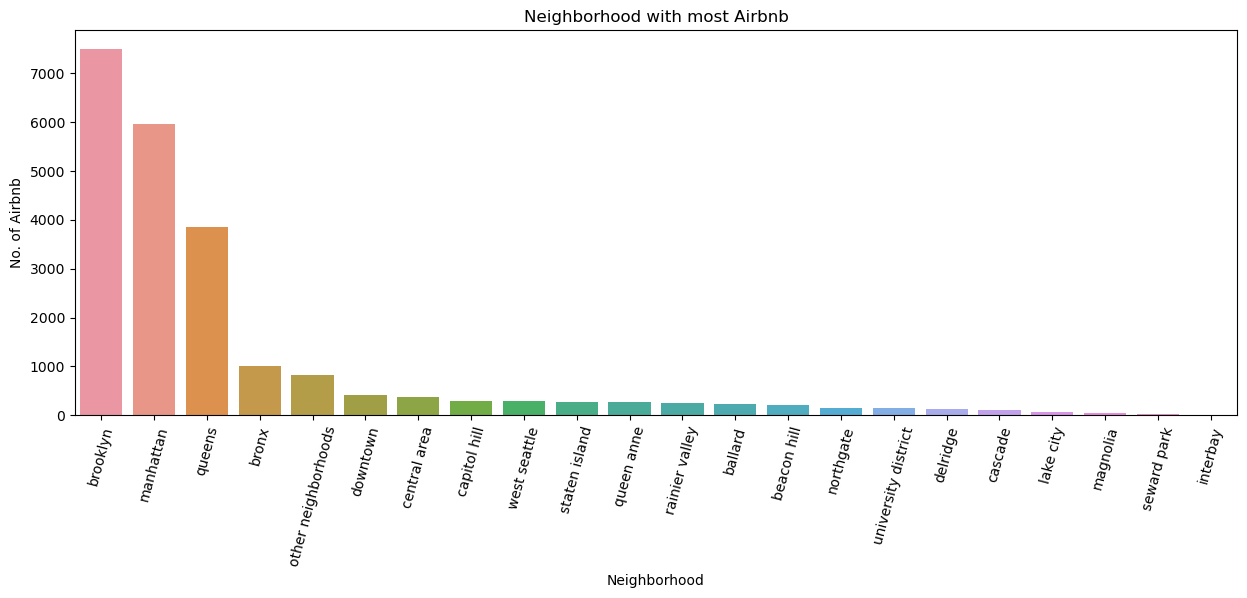

In [20]:
plt.figure(figsize=(15, 5))
highest_neighborhood = df['neighbourhood_group_cleansed'].value_counts().index
sns.countplot(data=df, x='neighbourhood_group_cleansed', order=highest_neighborhood)
plt.xticks(rotation=75)
plt.title('Neighborhood with most Airbnb')
plt.xlabel('Neighborhood')
plt.ylabel('No. of Airbnb')

# Exploratory Data Analysis 4: Plotting distributions of multiple columns
The distribution and spread of different features in the Airbnb dataset can be better understood using distribution graphs. To see the distribution of different features and to identify whether there are any outliers or unusual patterns.
We used this after using describe to check that there were no outliers in the columns like **accommodates, bedrooms, price, availability_365, review_scores_rating, amenities_count**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:



`distplot` is a deprec

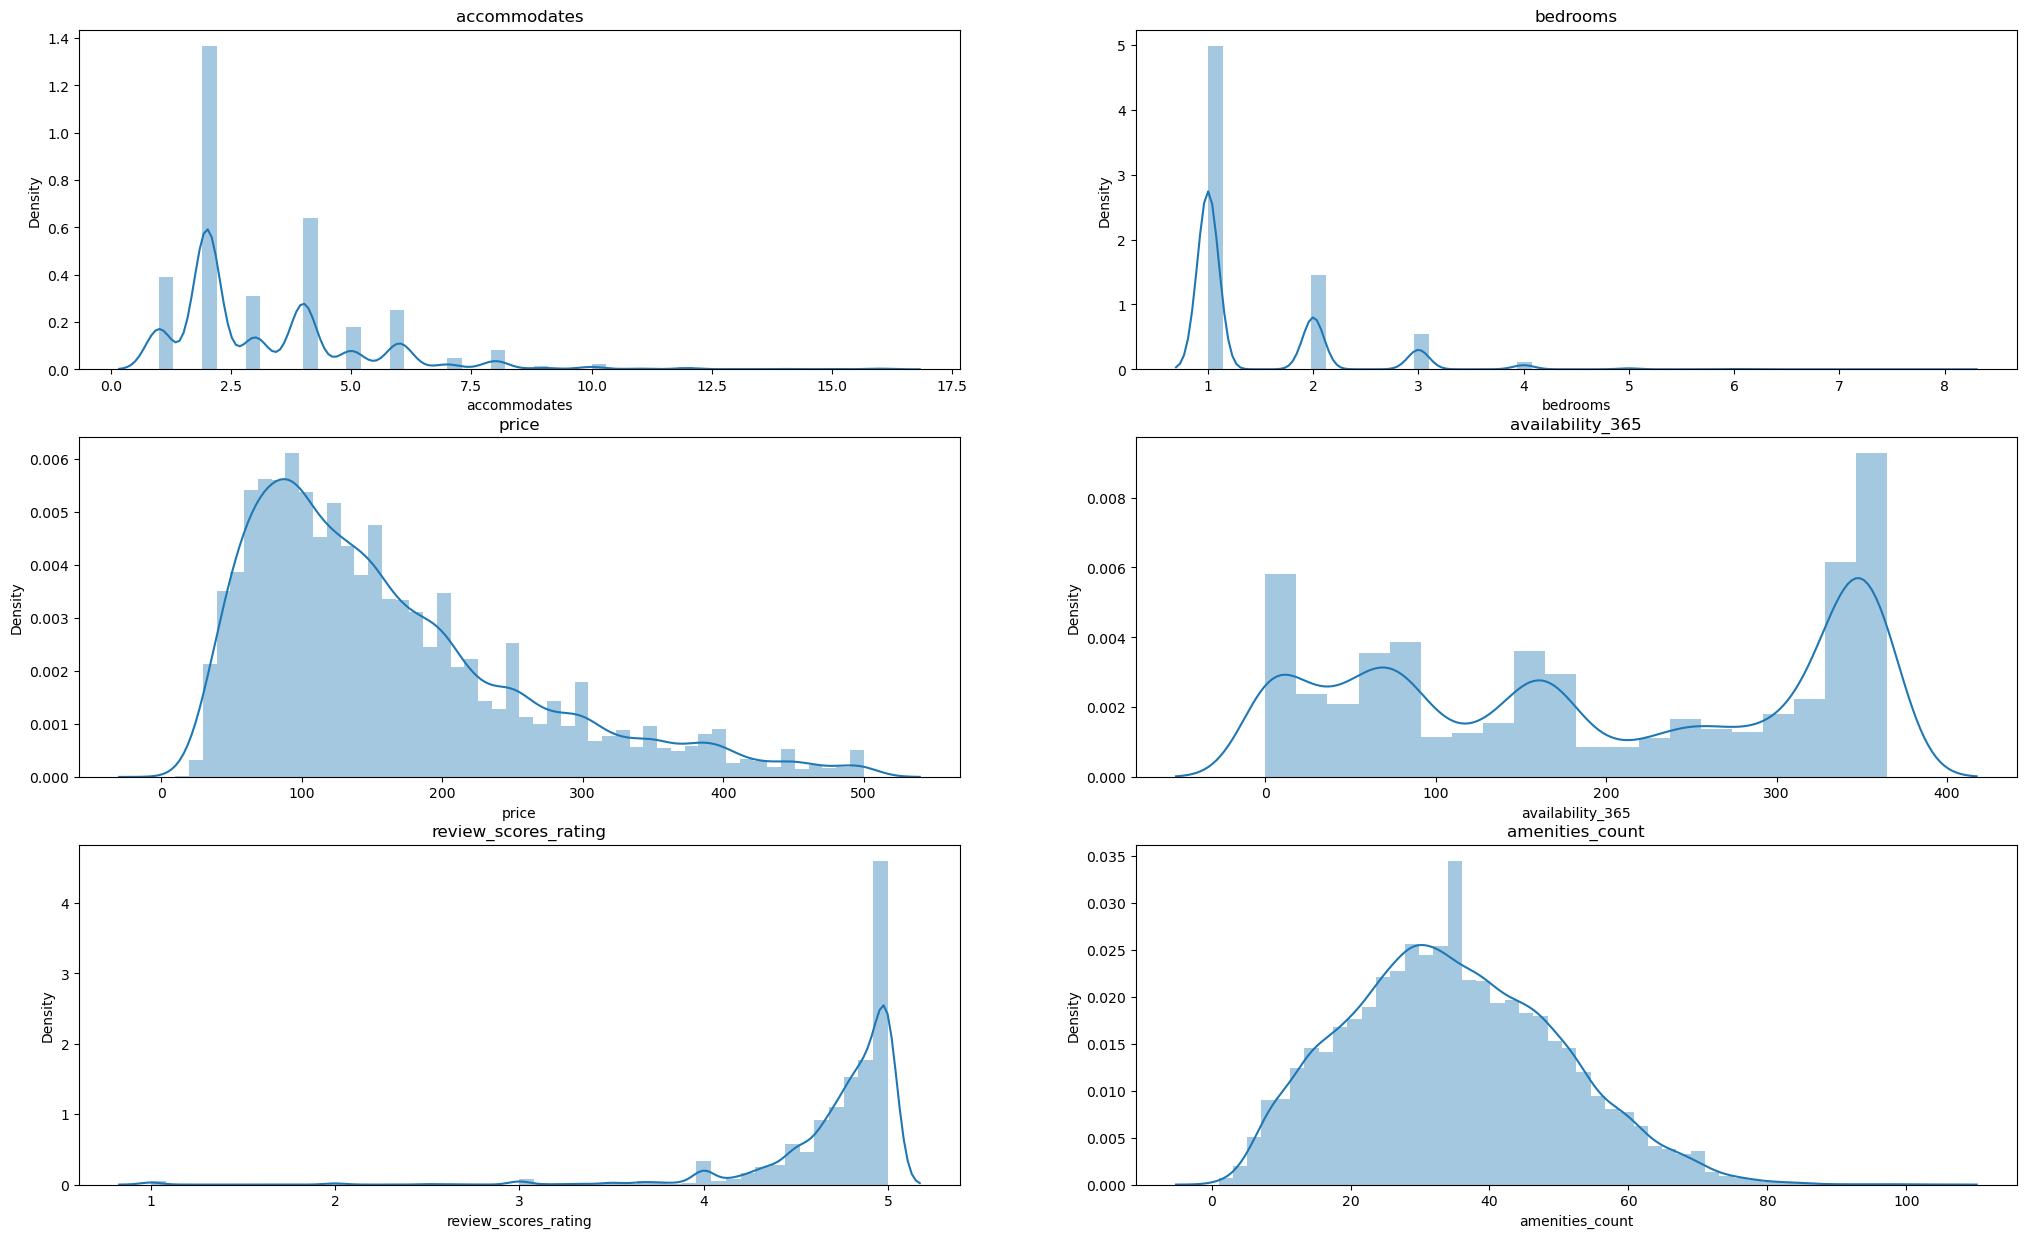

In [40]:
fig, ax = plt.subplots(3,2, figsize=(25,15))

r, c = 0, 0
for col in ['accommodates', 'bedrooms', 'price', 'availability_365', 'review_scores_rating', 'amenities_count']:
    ax[r][c].set_title(col)
    sns.distplot(df[col], ax=ax[r][c])
    c += 1
    if c == 2:
        r += 1
        c = 0

# Preprocessing 10: Binning ratings columns
The default ratings for each listings is of float type with continuous values in the range **[0, 5]**. To perform EDA and find its relationship with the different room types, the ratings were binned into **6** buckets **0, 1, 2, 3, 4, 5**. The EDA suggests that the room types does affect the ratings of the listing.

In [38]:
df['review_scores_rating_number'] = df['review_scores_rating'].apply(lambda x: round(x))

# Exploratory Data Analysis 5: Plotting Review Ratings against Room Type
Here in this graph we try too see whether the conjugation of room type with review rating Number can be related to adjust pricing . 
By incorporating the room type data and review score rating number data into the pricing model, we can adjust the recommended price based on the quality of the listing and the room type. 


In [39]:
px.histogram(df, x="room_type", color="review_scores_rating_number", barmode="group", title="Total Reviews")

# Exploratory Data Analysis 6: Plotting Histogram to check Frequency Distribution of columns
Histograms can show the frequency distribution of values for a given column, such as the price, number of bedrooms, or number of reviews, availability.
Using the histogram we learned that It can be easy to analyze and find outliers, unusual patterns in our data.

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_response_rate'}>,
        <AxesSubplot:title={'center':'host_is_superhost'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>],
       [<AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'availability_30'}>],
       [<AxesSubplot:title={'center':'availability_60'}>,
        <AxesSubplot:title={'center':'availability_90'}>,
        <AxesSubplot:title={'center':'availability_365'}>,


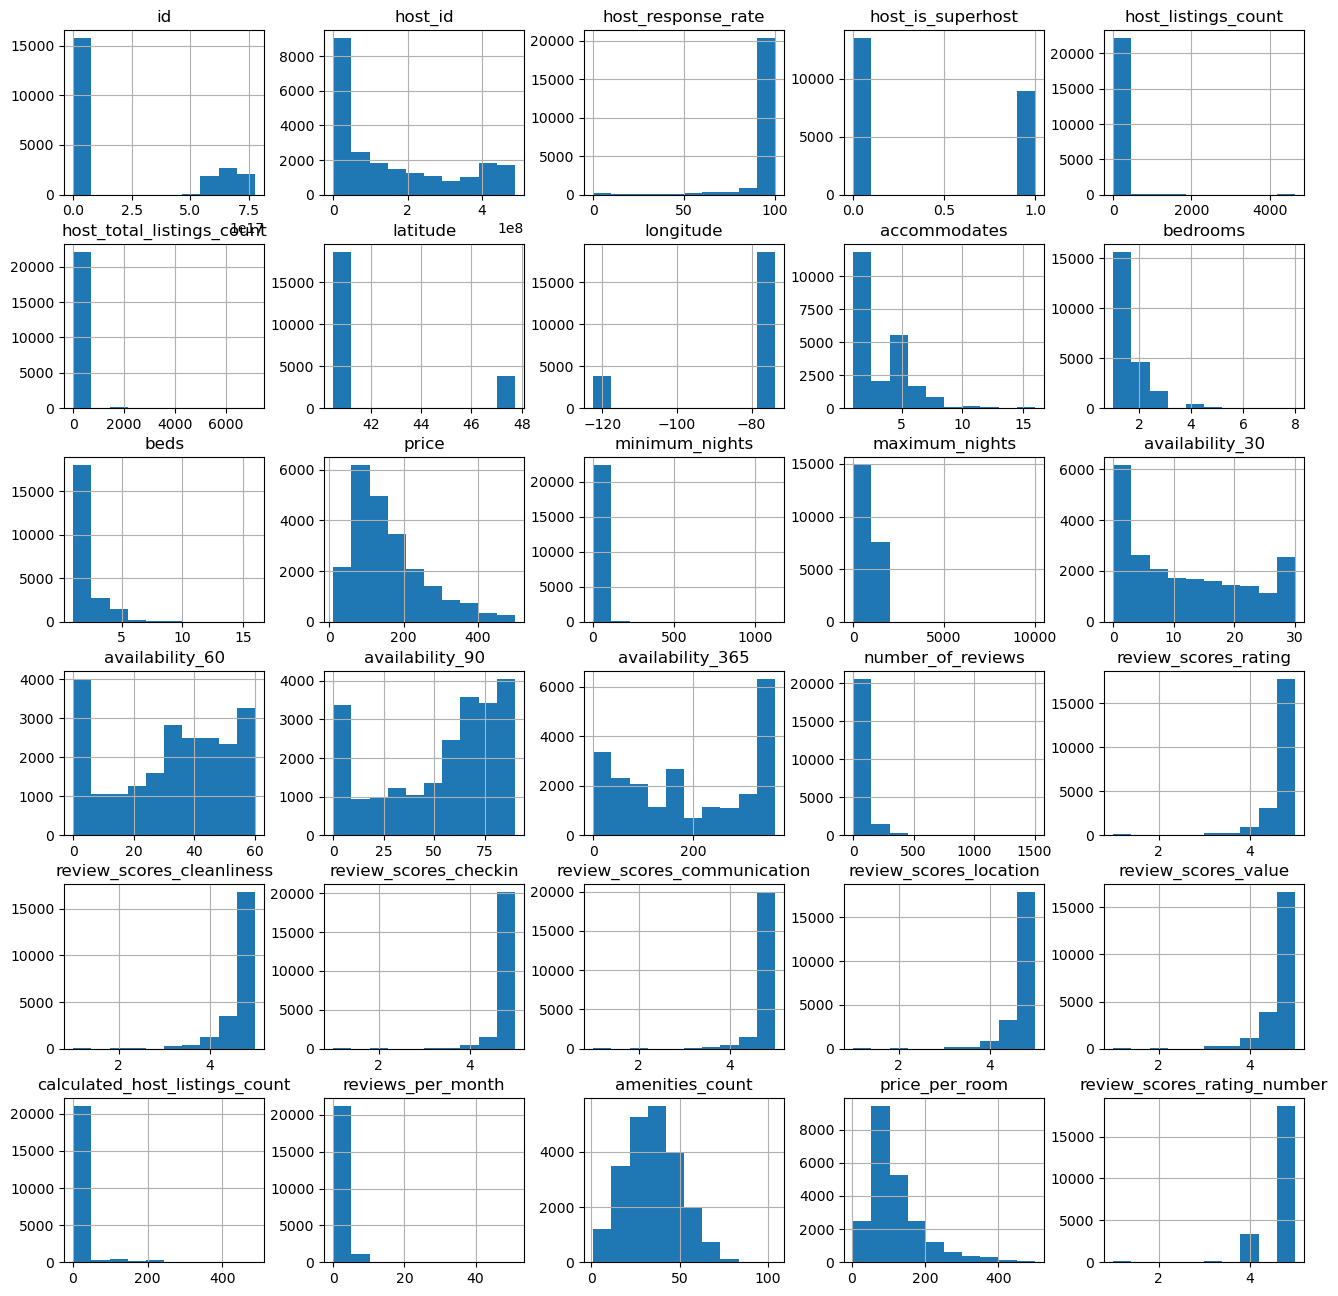

In [22]:
df.hist(figsize=(16,16))

# Exploratory Data Analysis 7: Scatter Plot of Longitude & Latitude with Price
We tried plotting two scatter plots of longitude and latitude. One with price and another with availability. This helped us identify that places with low availability have a higher price point which helped us in identifying that low availability in certain neighborhoods leads to high price which can help us adjust the pricing model that we build.

<AxesSubplot:title={'center':'Price'}, xlabel='longitude', ylabel='latitude'>

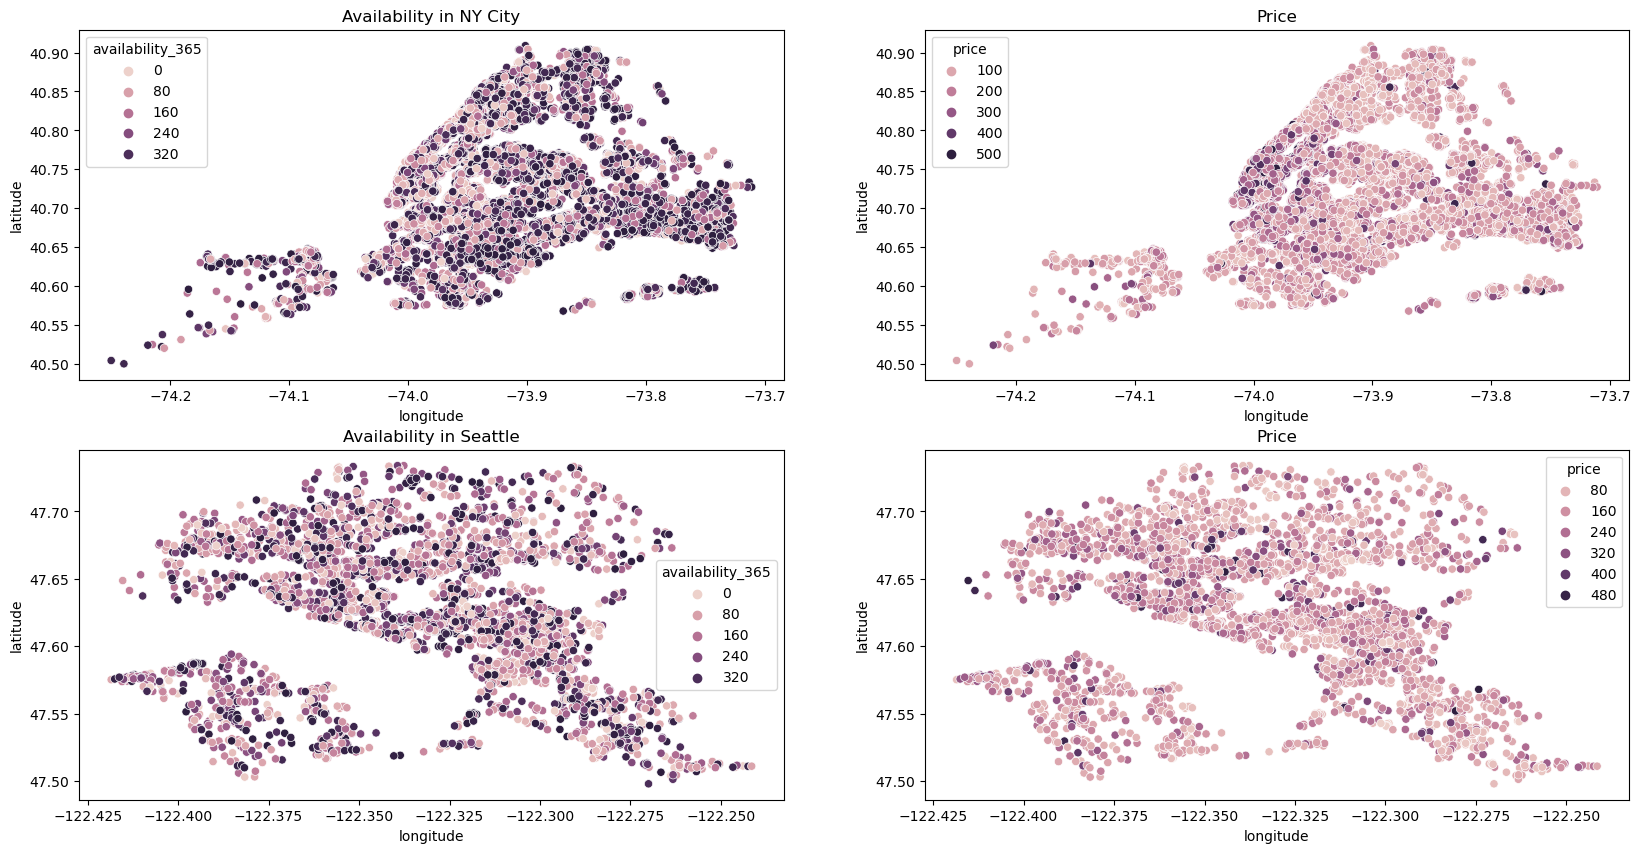

In [23]:
# EDA 5:
fig, ax = plt.subplots(2,2, figsize=(20,10))

# Dataframe for NY city
l = df[df['longitude'] > -80]

# Dataframe for Seattle
s = df[df['longitude'] < -80]

ax[0][0].set_title('Availability in NY City')
sns.scatterplot(x=l.longitude, y=l.latitude,hue=l.availability_365, ax=ax[0][0])

ax[0][1].set_title('Price')
sns.scatterplot(x=l.longitude, y=l.latitude,hue=l.price, ax=ax[0][1])

ax[1][0].set_title('Availability in Seattle')
sns.scatterplot(x=s.longitude, y=s.latitude,hue=s.availability_365, ax=ax[1][0])

ax[1][1].set_title('Price')
sns.scatterplot(x=s.longitude, y=s.latitude,hue=s.price, ax=ax[1][1])

# Exploratory Data Analysis 7: Influence of Room type, neighboorhood, bedrooms, accommodates on Price
Box plot can help us in seeing the range of values which in turn can help us in identifying patterns and outliers. Drawing the box plots for room type vs price we were able to infer that entire homes/ apartments have high price then shared rooms and private rooms.
This will help us in adjusting the price of our model.


In [24]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Box(y=df.price, x=df.room_type, name='Room Type vs Price', marker=dict(color='#3D9970')), row=1, col=1)
fig.add_trace(go.Box(y=df.price, x=df.neighbourhood_group_cleansed, name='Neighborhood vs Price'), row=1, col=2)
fig.add_trace(go.Box(y=df.price, x=df.bedrooms, name='Bedrooms vs Price'), row=2, col=1)
fig.add_trace(go.Box(y=df.price, x=df.accommodates, name='Accomodates vs Price'), row=2, col=2)
# fig.add_trace(go.Box(y=df.price, x=df.amenities_count, name='Amenities vs Price'), row=3, col=1)

fig.update_layout(height=1200, showlegend=True)


# Update xaxis properties
fig.update_xaxes(title_text="Room Type", showgrid=False, row=1, col=1)
fig.update_xaxes(title_text="Neighborhood", showgrid=False, row=1, col=2)
fig.update_xaxes(title_text="Bedrooms", showgrid=False, row=2, col=1)
fig.update_xaxes(title_text="Accomodates", showgrid=False, row=2, col=2)
# fig.update_xaxes(title_text="Amenities", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Price", showgrid=False, row=1, col=1)
fig.update_yaxes(title_text="Price", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="Price", showgrid=False, row=2, col=1)
fig.update_yaxes(title_text="Price", showgrid=False, row=2, col=2)
# fig.update_yaxes(title_text="Price", row=3, col=1)

fig.show()

# Exploratory Data Analysis 8: Correlation between multiple columns
The correlation matrix helps us identify correlation between different columns signifying to what extent these columns provide the same information. We removed beds and bedrooms since they had the highest correlation between them. Plotting this matrix helped us identifying columns which provide same information and we eliminated one of them since using both would not provide us extra value.

<AxesSubplot:>

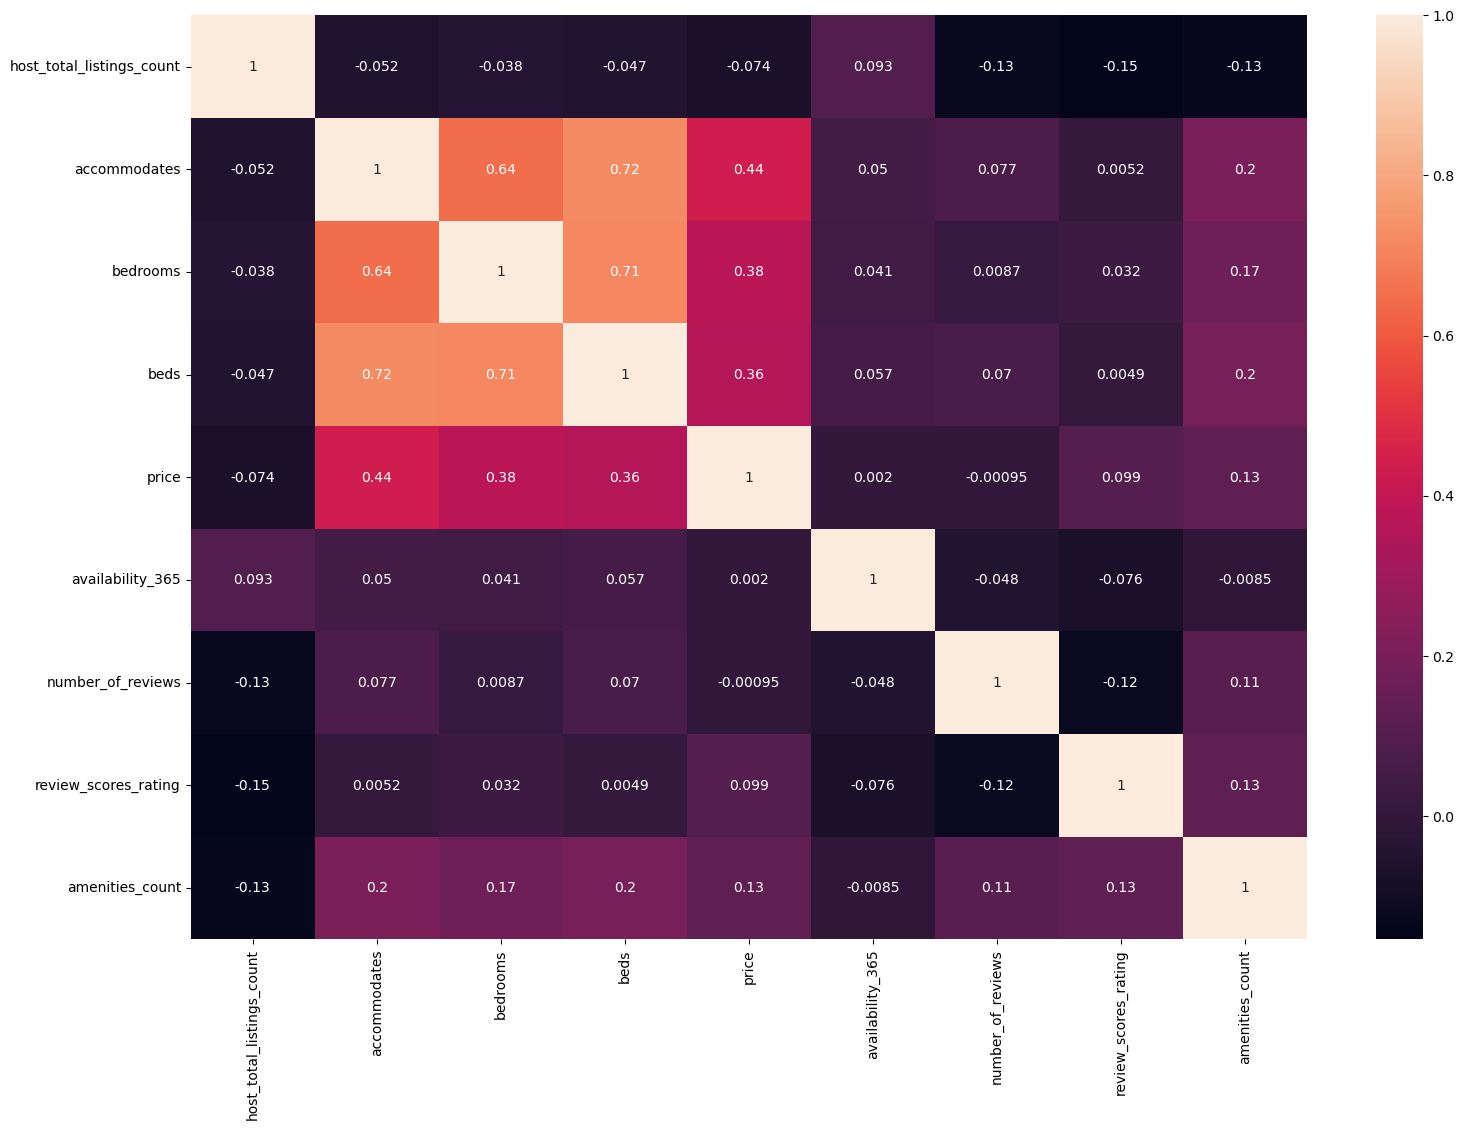

In [25]:
df_corr = df[['host_total_listings_count', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'amenities_count']]
correlation = df_corr.corr(method='kendall')
plt.figure(figsize=(18,12))
sns.heatmap(correlation, annot=True)

# Preprocessing 11: Remove columns with high correlation as they provide same information
Columns such a beds and bedrooms are highly correlated with each other. We believe that using beds along with bedrooms would provide no additional information. Thus, the beds column as been dropped.

In [26]:
df.drop('beds', inplace=True, axis=1)

# Exploratory Data Analysis 9: Scatter Plot between Review Score Rating vs Host Listing Count
We used the scatter plot to identify that there might be relation between the review score rating and host listing count as we though that host with more listing count might have less rating because he might not be able to give proper time. But by plotting the scatter plot we were able to find that these both are not correlated and can be both used for pricing model.

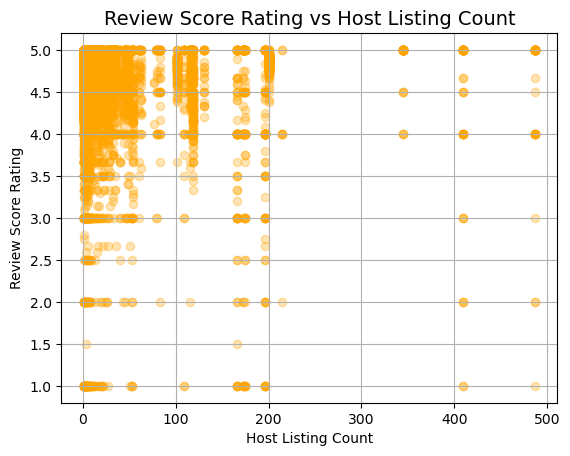

In [27]:
plt.scatter(df['calculated_host_listings_count'],df['review_scores_rating'],color='orange',alpha=0.3)
plt.xlabel('Host Listing Count')
plt.ylabel('Review Score Rating')
plt.title('Review Score Rating vs Host Listing Count', fontsize=14)
plt.grid(True)

plt.show()

# Exploratory Data Analysis 10: Price vs Amenities Scatter Plot
This plot was drawn to understand the correlation between price and amenities and how price varies with change in amenities . Using this plot we saw that there was a trend that price increased with increase in amenities. This again will be used for adjusting the price.
Also what we found out was there were only few houses with greater then 80 amenities and the data did not follow the trend for those few house apartments. This helped us in identifying them as outliers and removing them.
 

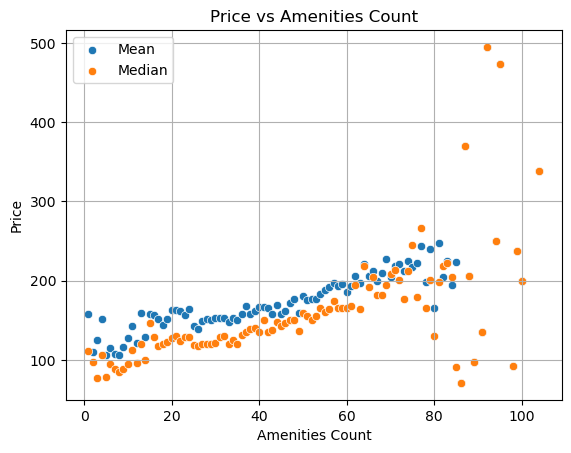

In [28]:
result = df.groupby('amenities_count')['price'].agg(['mean', 'median']).reset_index()

sns.scatterplot(data=result, x='amenities_count', y='mean', label='Mean')
sns.scatterplot(data=result, x='amenities_count', y='median', label='Median')
plt.title('Price vs Amenities Count')
plt.xlabel('Amenities Count')
plt.ylabel('Price')
plt.grid(True)
plt.show()

<h3>Removing outliers based on the above scatter plot</h3>

In [29]:
df = df[df['amenities_count'] < 90]

# Exploratory Data Analysis 11: Room type proportions in the dataset using Pie Chart
In this step we tried to plot a pie chart of the room types to check the proportion of data belonging to each Category.
Using the analysis we found out the data for hotel rooms is very less and that is why decided tom remove the hotel data as we did not have enough data about it.

In [30]:
result = df['room_type'].value_counts()
result
fig = px.pie(values=result.values, names=result.index, title="Room type by percentage", template="presentation")
fig.show()

<h3>Dropping hotel rooms since they have a lower contribution to total distribution</h3>

In [31]:
df = df[df['room_type'] != 'hotel room']